In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import torch
import torch.utils.data
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

import pvi
from pvi.models import ClassificationBNNLocalRepam
from pvi.clients import Client
from pvi.servers import SequentialServer
from pvi.distributions import MeanFieldGaussianDistribution, MeanFieldGaussianFactor
from pvi.utils.training_utils import EarlyStopping

In [2]:
data_dir = Path("/Users/terjemildner/Desktop/data")
cache_dir = Path("/Users/terjemildner/Desktop/PVI-main/experiments/femnist")

## Define various functions for splitting data and recording performance metrics.

In [3]:
# Data splitting functions.
def homogeneous_split(data, num_clients=100, seed=42):
    # Set numpy's random seed.
    np.random.seed(seed)
    
    perm = np.random.permutation(len(data["x"]))
    client_data = []
    for i in range(num_clients):
        client_idx = perm[i::num_clients]
        client_data.append({"x": data["x"][client_idx], "y": data["y"][client_idx]})
    
    return client_data


# Performance metric function. Why is the batch size 512 when the split gives 600? => Mini batches?
def performance_metrics(client, data, batch_size=512):
    dataset = torch.utils.data.TensorDataset(data["x"], data["y"])
    loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    
    device = client.config["device"]
    
    if device == "cuda":
        loader.pin_memory = True
        
    preds, mlls = [], []
    for (x_batch, y_batch) in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        pp = client.model_predict(x_batch)
        preds.append(pp.component_distribution.probs.mean(1).cpu())
        mlls.append(pp.log_prob(y_batch).cpu())
        
    mll = torch.cat(mlls).mean()
    preds = torch.cat(preds)
    acc = sum(torch.argmax(preds, dim=-1) == loader.dataset.tensors[1]) / len(
        loader.dataset.tensors[1]
    )
    
    return {"mll": mll, "acc": acc}

## Data preprocessing

In [4]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_set = datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform_train)
test_set = datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform_test)

train_data = {
    "x": ((train_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": train_set.targets,
}

test_data = {
    "x": ((test_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": test_set.targets,
}

In [5]:
# Get client splits.
client_data = homogeneous_split(train_data, 100, seed=42)


## Define configuration for server and clients

In [7]:
model_config = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 2e-3},
    "sigma_optimiser_params": {"lr": 2e-3},
    "early_stopping": EarlyStopping(25, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 512,
    "epochs": 2500,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
}

server_config = {
    **client_config,
    #100
    "max_iterations": 100,
}

## Set up model etc.

In [8]:
device = server_config["device"]

model = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model.num_parameters,)).to(device) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model.num_parameters,)).to(device),
}

init_factor_nat_params = {
    "np1": torch.zeros(model.num_parameters).to(device),
    "np2": torch.zeros(model.num_parameters).to(device),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients = []
size_training = 0
for i in range(100):
    data_i = client_data[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients.append(
        Client(
            data=data_i,
            model=model,
            t=t_i,
            config=client_config,
            val_data=test_data
        )
    )    
server = SequentialServer(model=model, p=p, clients=clients, config=server_config, init_q=init_q, data=train_data, val_data=test_data)

## Run PVI!

In [9]:
i = 0
while not server.should_stop():
    server.tick()

    # Obtain performance metrics.
    metrics = server.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics["val_mll"], metrics["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics["train_mll"], metrics["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 339.070.
Test mll: -0.486. Test acc: 0.819.
Train mll: -0.457. Train acc: 0.828.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 536.380.
Test mll: -0.452. Test acc: 0.835.
Train mll: -0.417. Train acc: 0.846.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 732.007.
Test mll: -0.435. Test acc: 0.843.
Train mll: -0.396. Train acc: 0.857.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 936.281.
Test mll: -0.421. Test acc: 0.849.
Train mll: -0.379. Train acc: 0.865.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 1131.041.
Test mll: -0.417. Test acc: 0.853.
Train mll: -0.372. Train acc: 0.868.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 1334.414.
Test mll: -0.412. Test acc: 0.854.
Train mll: -0.364. Train acc: 0.869.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 1529.344.
Test mll: -0.413. Test acc: 0.855.
Train mll: -0.364. Train acc: 0.871.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 1724.351.
Test mll: -0.413. Test acc: 0.854.
Train mll: -0.363. Train acc: 0.872.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 1918.704.
Test mll: -0.410. Test acc: 0.855.
Train mll: -0.359. Train acc: 0.872.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 2130.693.
Test mll: -0.412. Test acc: 0.854.
Train mll: -0.359. Train acc: 0.873.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 10.
Time taken: 2330.597.
Test mll: -0.408. Test acc: 0.856.
Train mll: -0.354. Train acc: 0.874.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 11.
Time taken: 2524.431.
Test mll: -0.409. Test acc: 0.856.
Train mll: -0.353. Train acc: 0.875.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 12.
Time taken: 2727.358.
Test mll: -0.406. Test acc: 0.857.
Train mll: -0.352. Train acc: 0.875.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 13.
Time taken: 2926.844.
Test mll: -0.406. Test acc: 0.855.
Train mll: -0.351. Train acc: 0.876.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 14.
Time taken: 3132.406.
Test mll: -0.408. Test acc: 0.856.
Train mll: -0.350. Train acc: 0.875.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 15.
Time taken: 3332.489.
Test mll: -0.408. Test acc: 0.853.
Train mll: -0.352. Train acc: 0.874.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 16.
Time taken: 3525.468.
Test mll: -0.409. Test acc: 0.857.
Train mll: -0.353. Train acc: 0.875.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 17.
Time taken: 3729.925.
Test mll: -0.407. Test acc: 0.856.
Train mll: -0.350. Train acc: 0.875.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 18.
Time taken: 3927.319.
Test mll: -0.408. Test acc: 0.855.
Train mll: -0.351. Train acc: 0.875.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 19.
Time taken: 4121.771.
Test mll: -0.407. Test acc: 0.856.
Train mll: -0.348. Train acc: 0.877.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 20.
Time taken: 4309.384.
Test mll: -0.408. Test acc: 0.857.
Train mll: -0.348. Train acc: 0.876.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 21.
Time taken: 4515.575.
Test mll: -0.407. Test acc: 0.857.
Train mll: -0.347. Train acc: 0.876.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 22.
Time taken: 4710.177.
Test mll: -0.409. Test acc: 0.857.
Train mll: -0.347. Train acc: 0.877.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 23.
Time taken: 4905.528.
Test mll: -0.408. Test acc: 0.856.
Train mll: -0.346. Train acc: 0.877.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 24.
Time taken: 5110.674.
Test mll: -0.404. Test acc: 0.858.
Train mll: -0.344. Train acc: 0.878.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 25.
Time taken: 5306.575.
Test mll: -0.407. Test acc: 0.857.
Train mll: -0.342. Train acc: 0.878.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 26.
Time taken: 5499.568.
Test mll: -0.407. Test acc: 0.857.
Train mll: -0.344. Train acc: 0.878.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 27.
Time taken: 5822.161.
Test mll: -0.407. Test acc: 0.855.
Train mll: -0.345. Train acc: 0.877.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 28.
Time taken: 6458.102.
Test mll: -0.406. Test acc: 0.856.
Train mll: -0.343. Train acc: 0.877.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 29.
Time taken: 7219.049.
Test mll: -0.405. Test acc: 0.858.
Train mll: -0.343. Train acc: 0.877.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 30.
Time taken: 7504.652.
Test mll: -0.407. Test acc: 0.856.
Train mll: -0.343. Train acc: 0.878.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 31.
Time taken: 7695.026.
Test mll: -0.406. Test acc: 0.857.
Train mll: -0.341. Train acc: 0.879.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 32.
Time taken: 7893.436.
Test mll: -0.405. Test acc: 0.855.
Train mll: -0.340. Train acc: 0.879.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 33.
Time taken: 8095.867.
Test mll: -0.404. Test acc: 0.857.
Train mll: -0.340. Train acc: 0.879.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 34.
Time taken: 8286.423.
Test mll: -0.406. Test acc: 0.855.
Train mll: -0.343. Train acc: 0.878.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 35.
Time taken: 8480.776.
Test mll: -0.402. Test acc: 0.858.
Train mll: -0.340. Train acc: 0.879.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 36.
Time taken: 8687.042.
Test mll: -0.405. Test acc: 0.855.
Train mll: -0.342. Train acc: 0.878.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 37.
Time taken: 8896.417.
Test mll: -0.404. Test acc: 0.856.
Train mll: -0.340. Train acc: 0.878.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 38.
Time taken: 9144.294.
Test mll: -0.403. Test acc: 0.857.
Train mll: -0.340. Train acc: 0.879.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 39.
Time taken: 9337.628.
Test mll: -0.405. Test acc: 0.858.
Train mll: -0.340. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 40.
Time taken: 10020.597.
Test mll: -0.404. Test acc: 0.858.
Train mll: -0.340. Train acc: 0.879.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 41.
Time taken: 10785.614.
Test mll: -0.406. Test acc: 0.858.
Train mll: -0.340. Train acc: 0.878.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 42.
Time taken: 10978.370.
Test mll: -0.404. Test acc: 0.857.
Train mll: -0.339. Train acc: 0.879.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 43.
Time taken: 11178.424.
Test mll: -0.407. Test acc: 0.856.
Train mll: -0.343. Train acc: 0.878.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 44.
Time taken: 11380.432.
Test mll: -0.407. Test acc: 0.859.
Train mll: -0.339. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 45.
Time taken: 11577.536.
Test mll: -0.403. Test acc: 0.858.
Train mll: -0.338. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 46.
Time taken: 11775.242.
Test mll: -0.405. Test acc: 0.858.
Train mll: -0.338. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 47.
Time taken: 11969.765.
Test mll: -0.403. Test acc: 0.859.
Train mll: -0.338. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 48.
Time taken: 12171.255.
Test mll: -0.405. Test acc: 0.857.
Train mll: -0.338. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 49.
Time taken: 12367.875.
Test mll: -0.406. Test acc: 0.856.
Train mll: -0.340. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 50.
Time taken: 12556.545.
Test mll: -0.404. Test acc: 0.858.
Train mll: -0.336. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 51.
Time taken: 12758.833.
Test mll: -0.405. Test acc: 0.857.
Train mll: -0.337. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 52.
Time taken: 12953.631.
Test mll: -0.403. Test acc: 0.859.
Train mll: -0.336. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 53.
Time taken: 13153.849.
Test mll: -0.403. Test acc: 0.858.
Train mll: -0.335. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 54.
Time taken: 13341.357.
Test mll: -0.406. Test acc: 0.855.
Train mll: -0.340. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 55.
Time taken: 13532.440.
Test mll: -0.402. Test acc: 0.857.
Train mll: -0.335. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 56.
Time taken: 13728.127.
Test mll: -0.401. Test acc: 0.856.
Train mll: -0.334. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 57.
Time taken: 13922.127.
Test mll: -0.402. Test acc: 0.858.
Train mll: -0.335. Train acc: 0.882.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 58.
Time taken: 14130.590.
Test mll: -0.404. Test acc: 0.858.
Train mll: -0.334. Train acc: 0.882.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 59.
Time taken: 14328.255.
Test mll: -0.401. Test acc: 0.858.
Train mll: -0.336. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 60.
Time taken: 14515.849.
Test mll: -0.405. Test acc: 0.857.
Train mll: -0.335. Train acc: 0.882.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 61.
Time taken: 14711.598.
Test mll: -0.404. Test acc: 0.858.
Train mll: -0.336. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 62.
Time taken: 14903.970.
Test mll: -0.404. Test acc: 0.858.
Train mll: -0.337. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 63.
Time taken: 15102.450.
Test mll: -0.402. Test acc: 0.859.
Train mll: -0.334. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 64.
Time taken: 15294.773.
Test mll: -0.404. Test acc: 0.856.
Train mll: -0.335. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 65.
Time taken: 15480.494.
Test mll: -0.402. Test acc: 0.861.
Train mll: -0.335. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 66.
Time taken: 16783.191.
Test mll: -0.401. Test acc: 0.859.
Train mll: -0.335. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 67.
Time taken: 16976.600.
Test mll: -0.403. Test acc: 0.859.
Train mll: -0.336. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 68.
Time taken: 17394.601.
Test mll: -0.403. Test acc: 0.859.
Train mll: -0.337. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 69.
Time taken: 17584.079.
Test mll: -0.402. Test acc: 0.859.
Train mll: -0.334. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 70.
Time taken: 17778.751.
Test mll: -0.404. Test acc: 0.856.
Train mll: -0.336. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 71.
Time taken: 18394.868.
Test mll: -0.402. Test acc: 0.858.
Train mll: -0.335. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 72.
Time taken: 18576.015.
Test mll: -0.404. Test acc: 0.858.
Train mll: -0.335. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 73.
Time taken: 19694.631.
Test mll: -0.403. Test acc: 0.858.
Train mll: -0.335. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 74.
Time taken: 20245.484.
Test mll: -0.406. Test acc: 0.857.
Train mll: -0.337. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 75.
Time taken: 20436.321.
Test mll: -0.404. Test acc: 0.859.
Train mll: -0.334. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 76.
Time taken: 21208.030.
Test mll: -0.405. Test acc: 0.856.
Train mll: -0.337. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 77.
Time taken: 21778.538.
Test mll: -0.404. Test acc: 0.857.
Train mll: -0.337. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 78.
Time taken: 21962.172.
Test mll: -0.405. Test acc: 0.858.
Train mll: -0.336. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 79.
Time taken: 23176.568.
Test mll: -0.404. Test acc: 0.858.
Train mll: -0.338. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 80.
Time taken: 23475.540.
Test mll: -0.404. Test acc: 0.858.
Train mll: -0.338. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 81.
Time taken: 23728.241.
Test mll: -0.403. Test acc: 0.858.
Train mll: -0.337. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 82.
Time taken: 24101.054.
Test mll: -0.405. Test acc: 0.856.
Train mll: -0.337. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 83.
Time taken: 24593.067.
Test mll: -0.405. Test acc: 0.859.
Train mll: -0.338. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 84.
Time taken: 25044.323.
Test mll: -0.406. Test acc: 0.859.
Train mll: -0.337. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 85.
Time taken: 25349.606.
Test mll: -0.405. Test acc: 0.860.
Train mll: -0.335. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 86.
Time taken: 26096.357.
Test mll: -0.406. Test acc: 0.858.
Train mll: -0.335. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 87.
Time taken: 26689.619.
Test mll: -0.404. Test acc: 0.858.
Train mll: -0.334. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 88.
Time taken: 26884.255.
Test mll: -0.406. Test acc: 0.858.
Train mll: -0.337. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 89.
Time taken: 27078.022.
Test mll: -0.404. Test acc: 0.858.
Train mll: -0.334. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 90.
Time taken: 27276.880.
Test mll: -0.404. Test acc: 0.858.
Train mll: -0.335. Train acc: 0.880.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 91.
Time taken: 27466.115.
Test mll: -0.403. Test acc: 0.858.
Train mll: -0.335. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 92.
Time taken: 27656.860.
Test mll: -0.404. Test acc: 0.857.
Train mll: -0.336. Train acc: 0.881.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

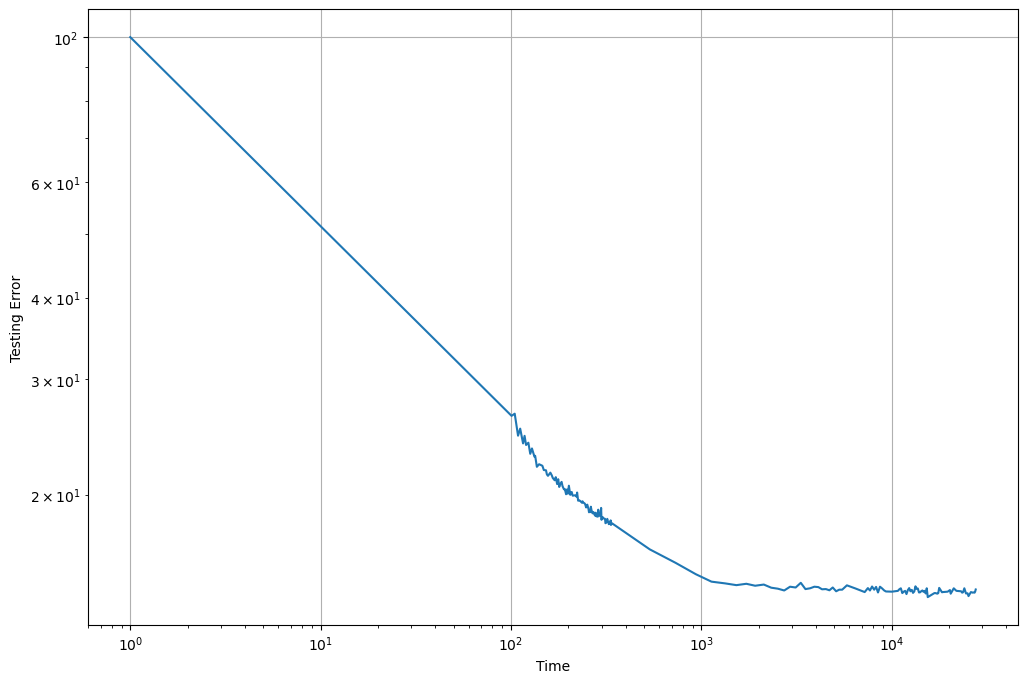

In [21]:
train_acc = []
val_acc = []
times = []
train_acc.append(100.0)
val_acc.append(100.0)
times.append(1.0)
for metrics in server.log["performance_metrics"]:
    train_acc.append(100-metrics["train_acc"]*100)
    val_acc.append(100-metrics["val_acc"]*100)
    times.append(metrics["time"])
plt.figure(figsize=(12,8))
plt.xscale("log")
plt.yscale("log")
plt.plot(times, val_acc)
plt.grid(visible=True)
plt.xlabel("Time")
plt.ylabel("Testing Error")
plt.savefig("PVI on FMNITS, lr=0.002.png")
plt.show()

In [22]:
val_acc[0]

100.0